## Assignment 1 
### \YU-CHIEH LIAO \a1915688

### 1. Reading datasets

In [1]:

# ===========================
# IMPORT LIBRARIES
# ===========================

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================
# NLP PROCESSING
# ===========================

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import ngrams

# Ensure necessary resources are available
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

import spacy
# nlp = spacy.load('en_core_web_sm')  # Load the spaCy English model

# ===========================
# MACHINE LEARNING
# ===========================

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, f1_score

from collections import Counter  # Used for word frequency analysis

# ===========================
# VISUALIZATION SETTINGS
# ===========================

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)





(GPT-4o,: could you help me organize the libraries I input)

In [2]:
# Download and use the template  Download templatefor your coding and analysis.
# read the JSON file into a DataFrame
corpus = pd.read_json('random_30000_hotel_reviews.JSON', lines=True)
print(corpus.head(2))
print(corpus.shape)

                                             ratings                  title  \
0  {'service': 1.0, 'cleanliness': 2.0, 'overall'...  “Horrible experience”   
1  {'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...            “Stay Away”   

                                                text  \
0  First of all we got there and they didn't have...   
1  Found Racist graffiti in the room. Request to ...   

                                              author     date_stayed  \
0  {'username': 'Kh3RD', 'num_reviews': 1, 'id': ...  September 2012   
1  {'username': 'TheUglyPhotographer', 'num_citie...       June 2011   

   offering_id  num_helpful_votes       date         id  via_mobile  
0        80138                  0 2012-09-19  140716137       False  
1       240151                  1 2011-06-27  114807323       False  
(30000, 10)


In [3]:
# Use development tempset for all experiments. Use training/testing sets for the final training/testing, to obtain the final results. 

def clean_tokenize_text(data)->str:

    #lowercase the text
    data = data.lower()

    #removing numbers
    data = re.sub(r'\d+', '', data)

    # remove allD(e.g. punctuation )
    data = re.sub(r'[^a-zA-Z0-9\s]', '', data)

    # tokenise the text
    tokens = word_tokenize(data)


    return pd.Series([tokens, data])


corpus[['tokens', 'clean_text']] = corpus.apply(lambda row: clean_tokenize_text(row['text']), axis=1)

print(corpus[['text','clean_text', 'tokens']].head())

                                                text  \
0  First of all we got there and they didn't have...   
1  Found Racist graffiti in the room. Request to ...   
2  Close to Union Square - hotel is a bit of a ma...   
3  I had a bad vibe about this place from the mom...   
4  After we received our "final" bill and left th...   

                                          clean_text  \
0  first of all we got there and they didnt have ...   
1  found racist graffiti in the room request to c...   
2  close to union square  hotel is a bit of a maz...   
3  i had a bad vibe about this place from the mom...   
4  after we received our final bill and left the ...   

                                              tokens  
0  [first, of, all, we, got, there, and, they, di...  
1  [found, racist, graffiti, in, the, room, reque...  
2  [close, to, union, square, hotel, is, a, bit, ...  
3  [i, had, a, bad, vibe, about, this, place, fro...  
4  [after, we, received, our, final, bill, and, l..

In [4]:
#  Split data into training (first 10000 lines), development (next 10000 lines) and test (remaining 10000 lines).
train_data = corpus.iloc[:10000].copy()
dev_data = corpus.iloc[10000:20000].copy()
test_data = corpus.iloc[20000:].copy()

### 2. Exploratory Data Analysis (EDA)

Distribution of "overall" ratings

In [5]:
# Extracting the "overall" rating from the 'ratings' column
dev_data['overall_rating'] = dev_data['ratings'].apply(lambda x: x["overall"])


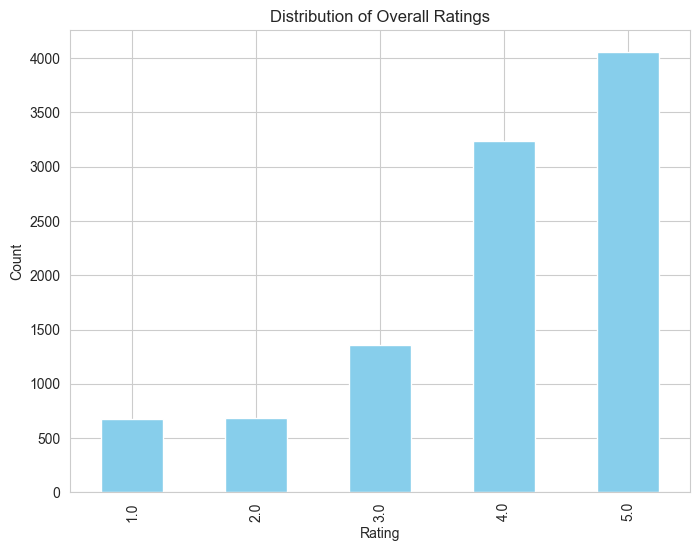

In [6]:
# Plot the distribution of overall ratings
plt.figure(figsize=(8, 6))
dev_data['overall_rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Distribution of Overall Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()





 Word frequency analysis

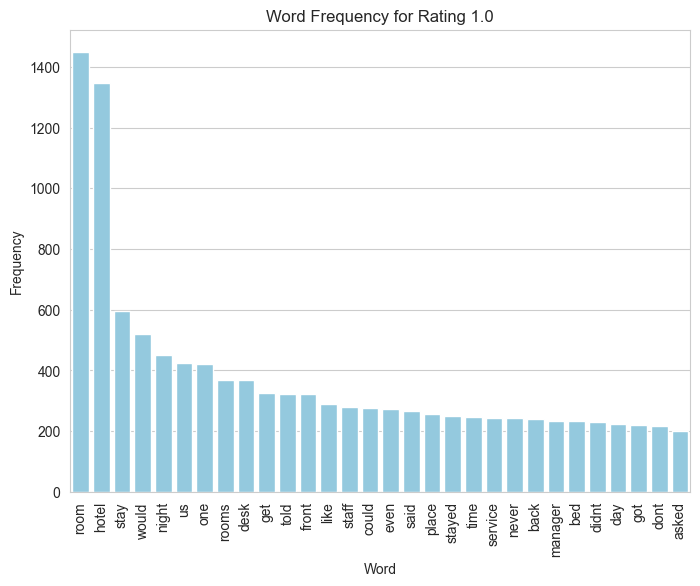

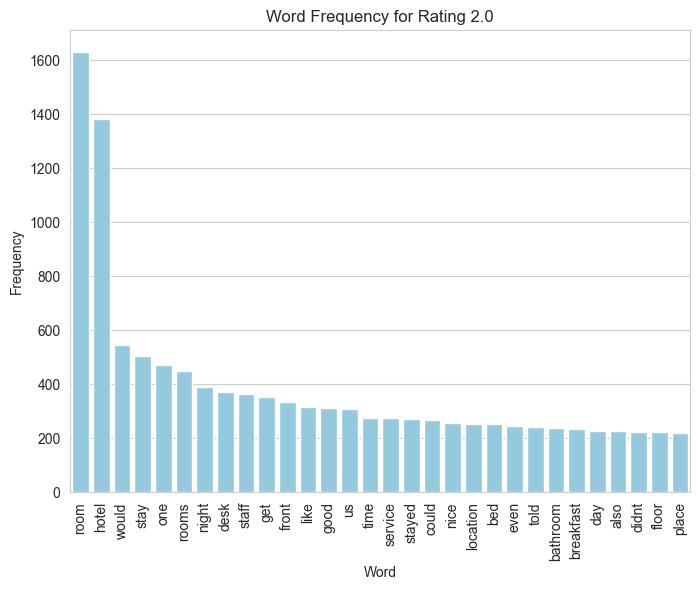

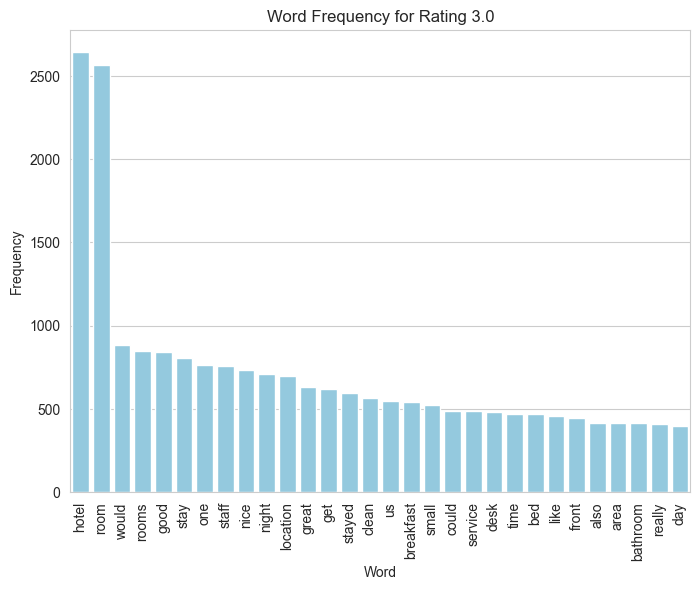

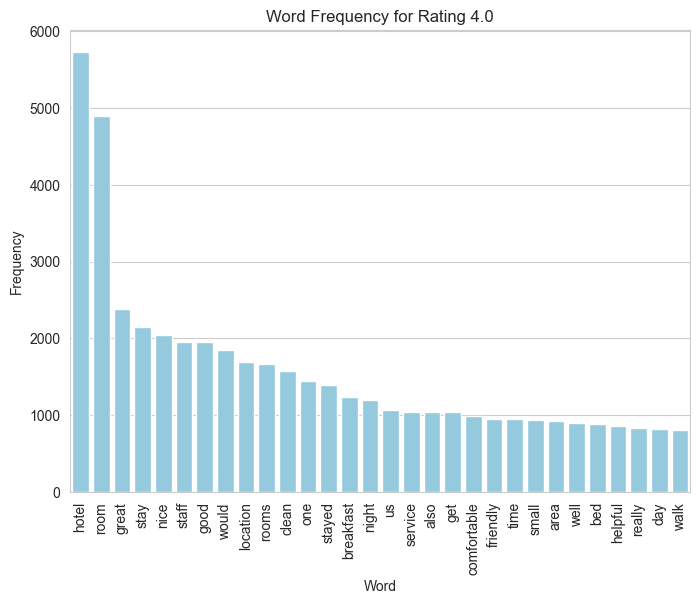

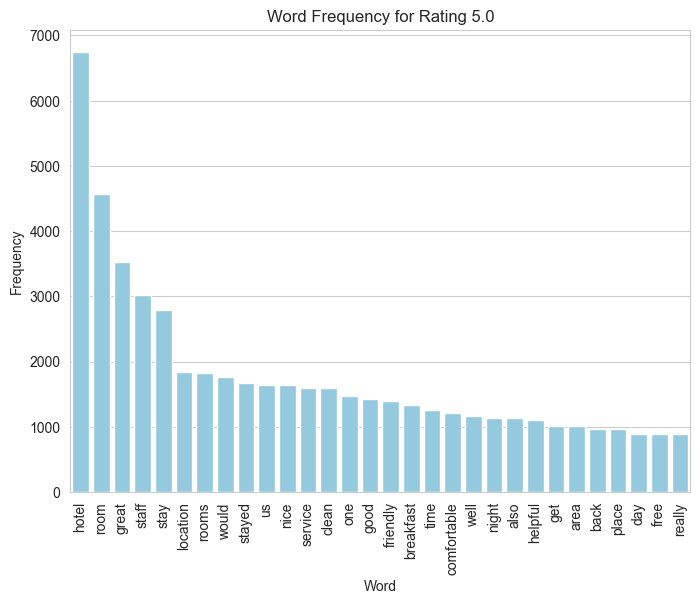

In [7]:
# based on the overall_rating column, create a word frequency plot for each rating category


#group the data by overall_rating
grouped = dev_data.groupby('overall_rating')

# plot the word frequency for each rating category
for rating, group in grouped:
    
    # get all tokens for the  same group
    all_tokens = [token for tokens in group['tokens'] for token in tokens]

    # remove stop words
    all_tokens = [token for token in all_tokens if token not in stop_words]

    # count the frequency of each word
    word_freq = Counter(all_tokens)

    
    # create a word frequency plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x=[word[0] for word in word_freq.most_common(30)], \
                y=[word[1] for word in word_freq.most_common(30)], color='skyblue')
    plt.title(f"Word Frequency for Rating {rating}")
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()


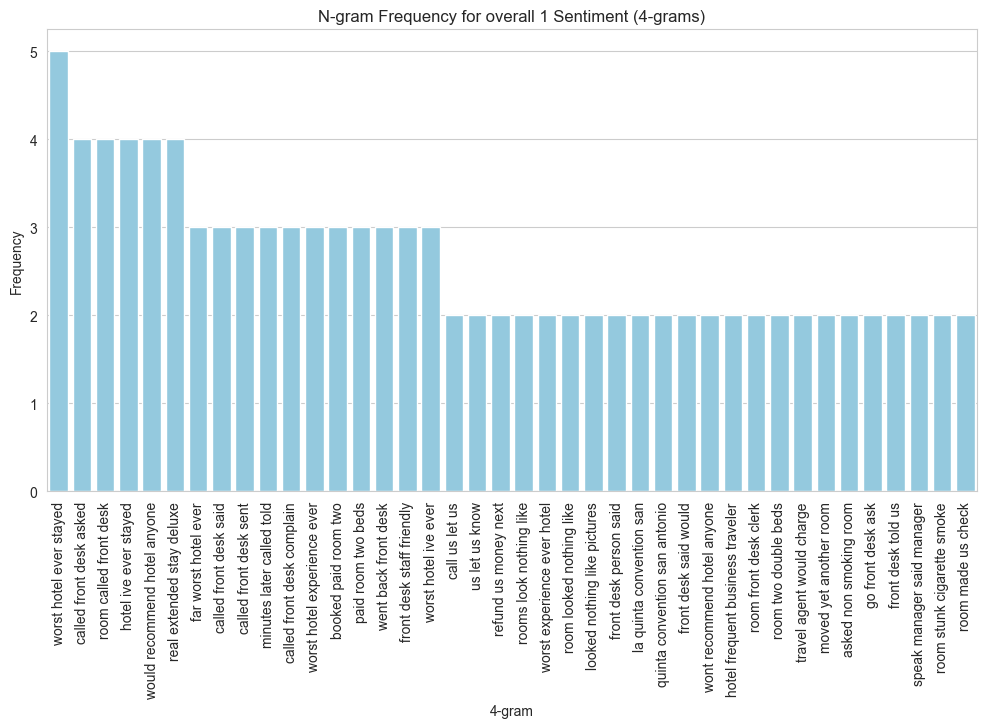

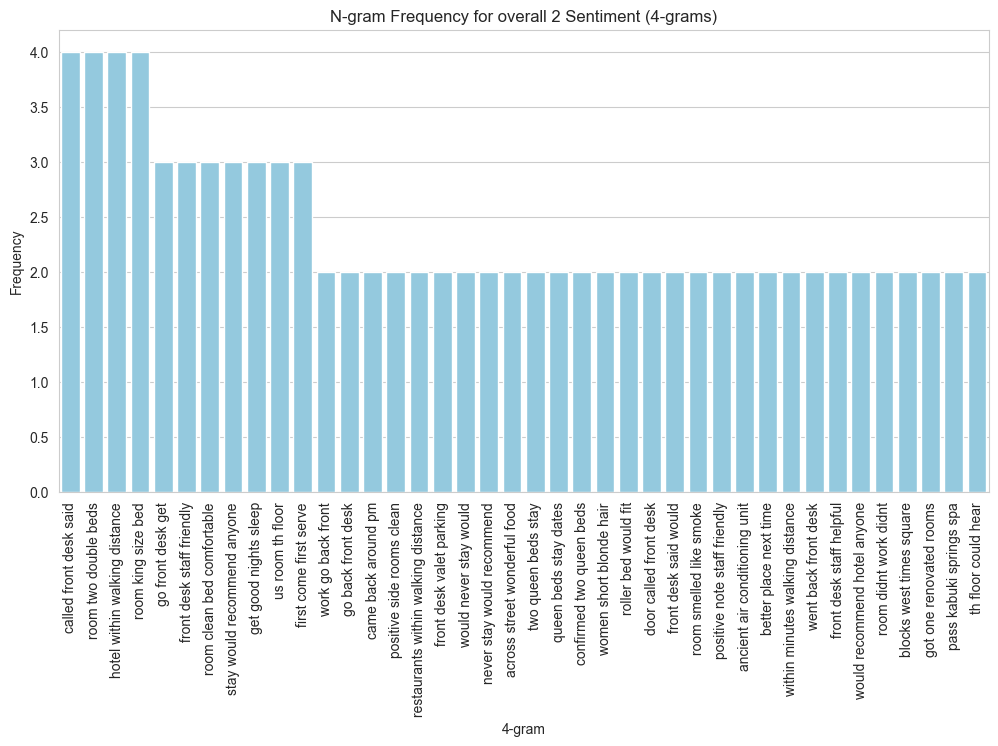

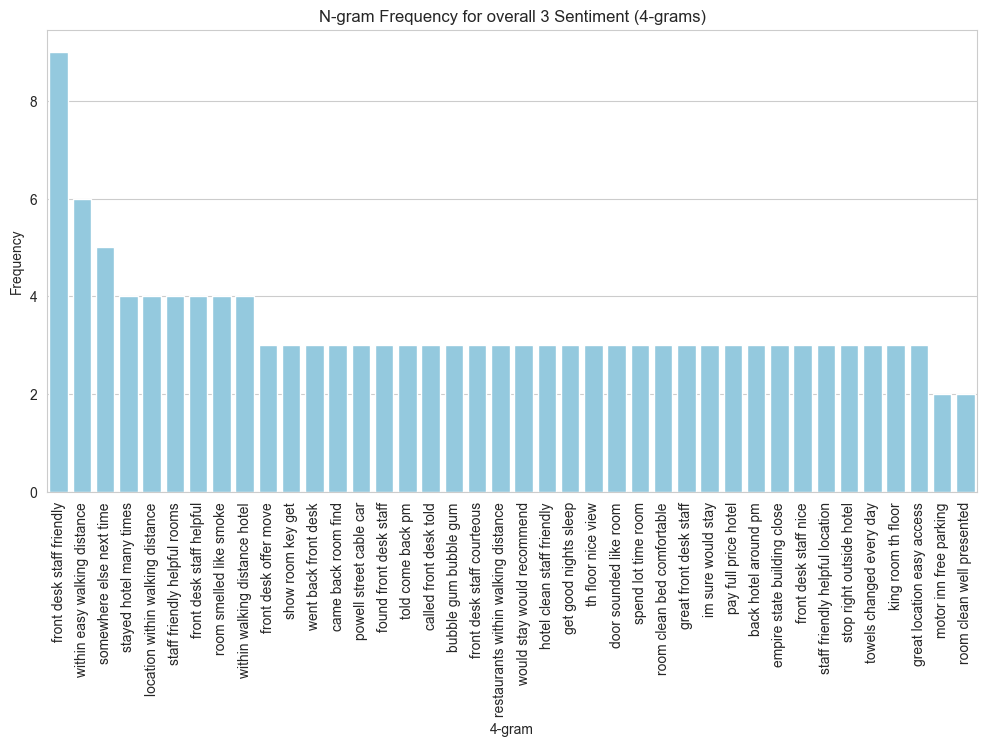

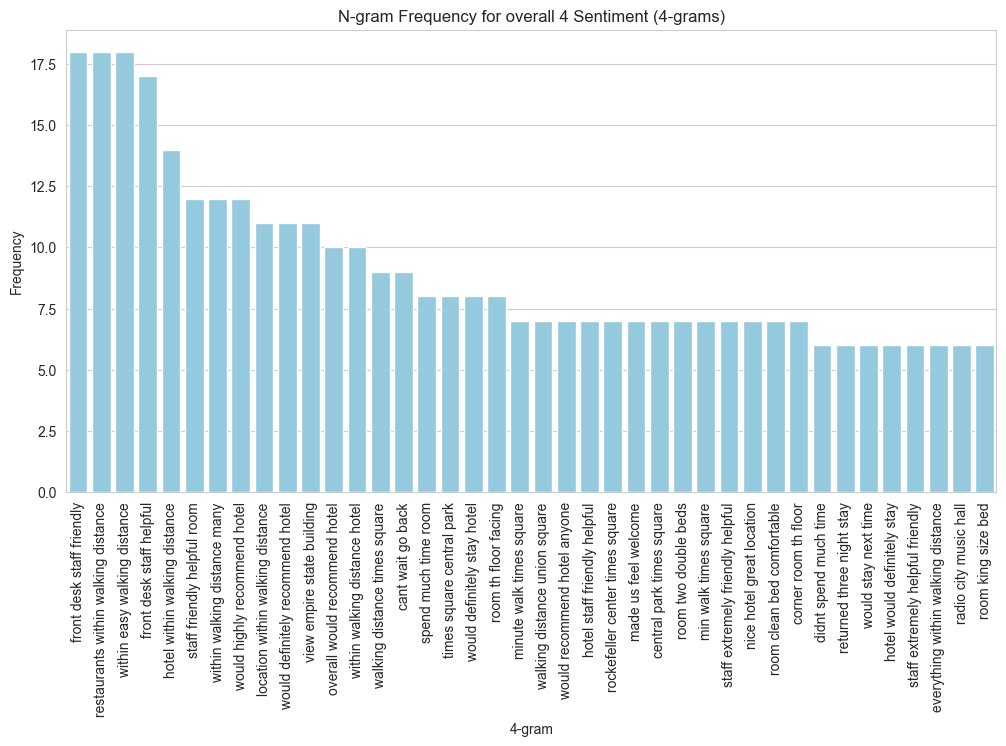

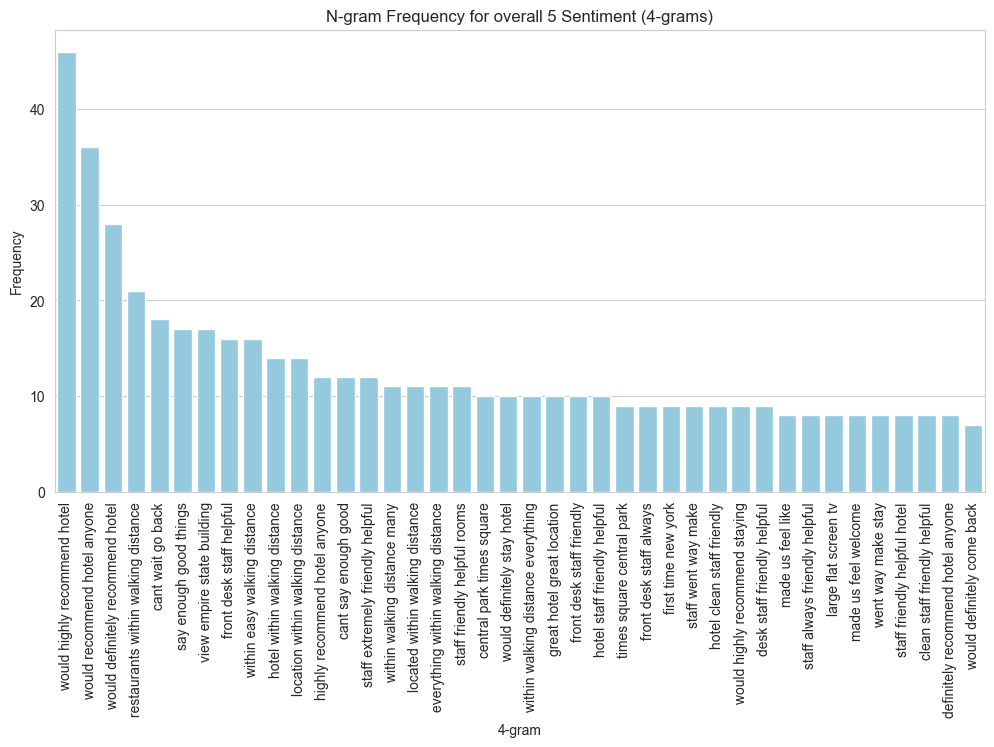

In [8]:


# Function to generate n-grams
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]


#  3 for trigrams, 2 for bigrams ... 
n = 4  


# remove stop words
temp_stop_token = dev_data['tokens'].copy().apply(lambda x: [token for token in x if token not in stop_words])
# Generate n-grams dynamically
dev_data[f'{n}-grams'] = temp_stop_token.apply(lambda x: generate_ngrams(x, n))

# Get all n-grams for rating 1
all_ove1_ngrams = [ngram for ngrams in dev_data[dev_data['overall_rating'] == 1][f'{n}-grams'] for ngram in ngrams]

# Get all n-grams for  rating 2
all_ove2_ngrams = [ngram for ngrams in dev_data[dev_data['overall_rating'] == 2][f'{n}-grams'] for ngram in ngrams]

# Get all n-grams for  rating 3
all_ove3_ngrams = [ngram for ngrams in dev_data[dev_data['overall_rating'] == 3][f'{n}-grams'] for ngram in ngrams]

all_ove4_ngrams = [ngram for ngrams in dev_data[dev_data['overall_rating'] == 4][f'{n}-grams'] for ngram in ngrams]

all_ove5_ngrams = [ngram for ngrams in dev_data[dev_data['overall_rating'] == 5][f'{n}-grams'] for ngram in ngrams]



# Count the frequency of each n-gram
ove1_ngram_freq = Counter(all_ove1_ngrams)
ove2_ngram_freq = Counter(all_ove2_ngrams)
ove3_ngram_freq = Counter(all_ove3_ngrams)
ove4_ngram_freq = Counter(all_ove4_ngrams)
ove5_ngram_freq = Counter(all_ove5_ngrams)


# Function to plot n-gram frequencies
def plot_ngram_frequency(ngram_freq, title, color):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[ngram[0] for ngram in ngram_freq.most_common(40)], 
                y=[ngram[1] for ngram in ngram_freq.most_common(40)], color=color)
    plt.title(f"{title} ({n}-grams)")
    plt.xlabel(f"{n}-gram")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()

# Plot for positive sentiment
plot_ngram_frequency(ove1_ngram_freq, "N-gram Frequency for overall 1 Sentiment", 'skyblue')

# Plot for negative sentiment
plot_ngram_frequency(ove2_ngram_freq, "N-gram Frequency for overall 2 Sentiment", 'skyblue')

# Plot for neutral sentiment
plot_ngram_frequency(ove3_ngram_freq, "N-gram Frequency for overall 3 Sentiment", 'skyblue')

plot_ngram_frequency(ove4_ngram_freq, "N-gram Frequency for overall 4 Sentiment",  'skyblue')

plot_ngram_frequency(ove5_ngram_freq, "N-gram Frequency for overall 5 Sentiment", 'skyblue')













In [9]:


# check the distribution of the overall ratings in the test set
for i in range(1, 6):
    print(f"Number of reviews with overall rating {i}: {dev_data[dev_data['overall_rating'] == i].shape[0]}")


Number of reviews with overall rating 1: 672
Number of reviews with overall rating 2: 684
Number of reviews with overall rating 3: 1353
Number of reviews with overall rating 4: 3237
Number of reviews with overall rating 5: 4054


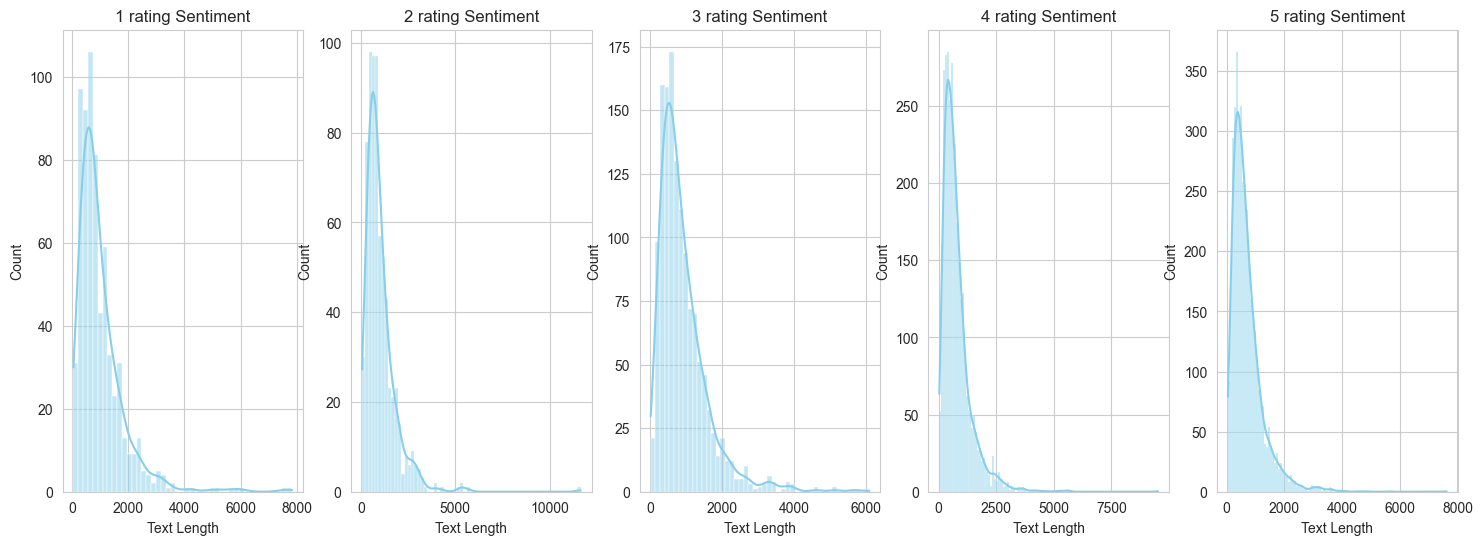

In [10]:


# check the distribution of the overall ratings in terms of the text length

def text_length(text):
    return len(text)


# the length of the text
dev_data['text_length'] = dev_data['clean_text'].apply(text_length)

# plot the distribution of text length for each sentiment category
plt.figure(figsize= (18, 6))


for i in range (1,6):
    plt.subplot(1, 5, i)
    sns.histplot(dev_data[dev_data['overall_rating'] == i]['text_length'], color='skyblue', kde=True)
    plt.title(f"{i} rating Sentiment")
    plt.xlabel("Text Length")
    plt.ylabel("Count")






# Feature Engineering

Model Selection

I chose Multinomial Naïve Bayes (MNB) for this report because our data is mainly made up of text-based predictors and an overall rating response, which makes it a great fit. MNB works really well for text classification since it assumes word frequencies follow a multinomial distribution. Plus, it pairs nicely with TF-IDF or CountVectorizer, making training both fast and scalable, even with large datasets. Since MNB is widely used for sentiment analysis and document classification, it was the best choice for our task. 

### 3. Preprocessing

Upsampling (Increase the number of minority class samples)

or

Downsampling (Reduce the number of majority class samples)

In [11]:



def upsampling(data):
    temp = data.copy()
    dataset = {}
    amount = []

    # Separate data by class
    for i in range(1, 6):
        dataset[f'all{i}_data'] = temp[temp['overall_rating'] == i]
        amount.append(dataset[f'all{i}_data'].shape[0])

    # Find the majority class size
    max_samples = max(amount)
    
    # Check for classes with zero samples
    for i in range(1, 6):
        if amount[i-1] == 0:
            print(f"Skipping class {i} as it has zero samples.")
            continue

        if amount[i-1] < max_samples:
            dataset[f'all{i}_data_upsampled'] = resample(
                dataset[f'all{i}_data'],
                replace=True,
                n_samples=max_samples,
                random_state=42
            )
        else:
            dataset[f'all{i}_data_upsampled'] = dataset[f'all{i}_data']

    # Combine all upsampled datasets
    data_upsampled = pd.concat([dataset[f'all{i}_data_upsampled'] for i in range(1, 6) if f'all{i}_data_upsampled' in dataset])

    # Shuffle dataset making it random
    data_upsampled = data_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

    return data_upsampled
            




def downsampling(data):

    temp = data.copy()
    
    dataset = {}
    amount = []

    for i in range(1,6):
        dataset[f'all{i}_data'] = temp[temp['overall_rating'] == i]
        amount.append(dataset[f'all{i}_data'].shape[0])

    # find the minority class
    min_index = amount.index(min(amount)) + 1

    # Downsample
    for i in range(1, 6):
        if amount[i-1] == 0:
            print(f"Skipping class {i} as it has zero samples.")
            continue
        if i != min_index:
            dataset[f'all{i}_data_downsampled'] = resample(dataset[f'all{i}_data'], 
                                                           replace=False,  # sample without replacement
                                                           n_samples=amount[min_index-1],  # match the minority class
                                                           random_state=42)
        else:
            dataset[f'all{i}_data_downsampled'] = dataset[f'all{i}_data']

    # Combine all the downsampled datasets
    data_downsampled = pd.concat([dataset[f'all{i}_data_downsampled'] for i in range(1, 6)])

    # Shuffle the downsampled dataset
    data_downsampled = data_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

    return data_downsampled




senti_model = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    sentiment_score = senti_model.polarity_scores(text)['compound']

    if sentiment_score >= -1.0 and sentiment_score < -0.6:
        return 1
    elif sentiment_score >= -0.6 and sentiment_score < -0.2:
        return 2
    elif sentiment_score >= -0.2 and sentiment_score < 0.2:
        return 3
    elif sentiment_score >= 0.2 and sentiment_score < 0.6:
        return 4
    else:
        return 5



(GPT-4o,: Could you give me a example of how to use scikit-learn to implement upsample and downsample, and explain how this tool multiply data and decrease data)

### 4. Selecting supervised method for sentiment classification

I went with the Bayes classifier because I’ll be using TF-IDF or CountVectorizer to turn the text into a sparse matrix or a set of weighted numbers. Multinomial Naïve Bayes (MNB) handles this kind of data really well—it’s fast, efficient, and works great for large datasets. SVM would take much longer to train, and Random Forest doesn’t handle sparse text features as well, so MNB was the better choice.

impliment 10-fold cross validation 

In [12]:


# Ensure stopwords and lemmatizer are available
# nltk.download('stopwords')
# nltk.download('wordnet')

# Load English stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()





# function to lowercase, split, remove stopwords and lemmatize the text

def feature_extraction(data,remove_stopwords=False, lemmatize=False):

    processed_data = data[['clean_text', 'overall_rating']].copy()

    processed_data['clean_text'] = processed_data['clean_text'].apply(lambda x: x.lower())

    # split is more fast than word_tokenize, which is more suitable for clean text
    # processed_data['clean_text'] =  processed_data['clean_text'].apply(lambda x: x.split())

    #tokenize the text 
    processed_data['clean_text'] = processed_data['clean_text'].apply(lambda x: word_tokenize(x))

    processed_data

    if remove_stopwords:
        processed_data['clean_text'] = processed_data['clean_text'].apply(lambda x: [word for word in x if word not in stop_words])

    if lemmatize:
        processed_data['clean_text'] = processed_data['clean_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


    processed_data['clean_text'] = processed_data['clean_text'].apply(lambda x: ' '.join(x))



    return processed_data



    
clean_data = feature_extraction(dev_data)
stop_remove_data = feature_extraction(dev_data, remove_stopwords=True)
stop_remove_lemma_data = feature_extraction(dev_data, remove_stopwords=True, lemmatize=True)





def evaluation(data, vader=False):
    # Prepare feature and target data
    x = data.drop('overall_rating', axis=1)
    y = data['overall_rating']

    # Set up 10-fold cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Vectorizer dictionary
    vector_types = {'TfidfVector': TfidfVectorizer()}

    for vector_name, vector in vector_types.items():
        # Initialize lists to store evaluation metrics
        accuracy_list, f1_list, f1_macro_list, f1_micro_list = [], [], [], []

        # Cross-validation loop
        for fold, (train_index, test_index) in enumerate(skf.split(x, y), 1):
            print(f"Fold {fold}...")

            # Split data into train and test based on indices
            train_data, test_data = data.iloc[train_index], data.iloc[test_index]

            # Apply vectorizer to train data
            X_train = vector.fit_transform(train_data['clean_text'])
            y_train = train_data['overall_rating']

            # Convert to DataFrame for easier manipulation
            train_data_vec = pd.DataFrame.sparse.from_spmatrix(X_train, index=train_data.index, columns=vector.get_feature_names_out())
            train_data_vec['overall_rating'] = y_train
            train_data_vec = train_data_vec.astype('float32')

            # Optionally include sentiment score (VADER)
            if vader:
                train_data_vec = pd.concat([train_data_vec, train_data['sentiment_score'].astype('float32')], axis=1)

            # Upsample or downsample training data
            train_data_vec = upsampling(train_data_vec)

            # Apply the vectorizer to test data
            X_test_vec = vector.transform(test_data['clean_text'])
            X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec, index=test_data.index, columns=vector.get_feature_names_out()).astype('float32')

            # Optionally include sentiment score (VADER) for test data
            if vader:
                X_test_vec = pd.concat([X_test_vec, test_data['sentiment_score'].astype('float32')], axis=1)

            y_test = test_data['overall_rating']

            # Train Multinomial Naive Bayes model
            mnb = MultinomialNB()
            mnb.fit(train_data_vec.drop('overall_rating', axis=1), train_data_vec['overall_rating'])

            # Make predictions
            y_pred = mnb.predict(X_test_vec)

            # Calculate evaluation metrics
            accuracy_list.append(accuracy_score(y_test, y_pred))
            f1_list.append(f1_score(y_test, y_pred, average='weighted'))
            f1_macro_list.append(f1_score(y_test, y_pred, average='macro'))
            f1_micro_list.append(f1_score(y_test, y_pred, average='micro'))

        # Print average metrics after all folds
        print(f"Vector Type: {vector_name}")
        print(f"Average Accuracy: {np.mean(accuracy_list):.4f}")
        print(f"Average F1 Score (Weighted): {np.mean(f1_list):.4f}")
        print(f"Average F1 Score (Macro): {np.mean(f1_macro_list):.4f}")
        print(f"Average F1 Score (Micro): {np.mean(f1_micro_list):.4f}")
        print()


(GPT-4o,: Could you advise me on the appropriate order for processing data, extracting features, and inputting the data into a model? (e.g., data processing such as stopword removal, lowercasing, lemmatization, sampling, TF-IDF/CountVectorizer, etc))

(GPT-4o,: Could you make my code more organized)

In [ ]:
print("Clean Data")
evaluation(clean_data)



print("Stopwords Removed Data")
evaluation(stop_remove_data)



print("stop_remove_lema_data")
evaluation(stop_remove_lemma_data)

Clean Data
Vector Type: TfidfVector
Average Accuracy: 0.4516
Average F1 Score: 0.4706
Average F1 Score (Macro): 0.4419
Average F1 Score (Micro): 0.4516

Stopwords Removed Data
Vector Type: TfidfVector
Average Accuracy: 0.4881
Average F1 Score: 0.5036
Average F1 Score (Macro): 0.4680
Average F1 Score (Micro): 0.4881

stop_remove_lema_data
Vector Type: TfidfVector
Average Accuracy: 0.4902
Average F1 Score: 0.5059
Average F1 Score (Macro): 0.4697
Average F1 Score (Micro): 0.4902



The reason for using stopword removal and lemmatization with TF-IDF is to enhance text preprocessing for better feature extraction. After basic preprocessing—such as lowercasing for consistency and removing punctuation or unnecessary characters—the text is tokenized using spaCy. Common stopwords like "the" and "is" are removed since they don’t add much meaning. Lemmatization then reduces words to their base forms, transforming "running" into "run" to ensure consistency. Finally, the cleaned text is converted into a single string, making it ready for feature extraction with TF-IDF or CountVectorizer. This approach helps the model focus on meaningful words while reducing noise, ultimately improving performance.

### 5. Sentiment classification using VADER lexicon and method


✅ VADER Model Accuracy: 0.4540

💡 **Classification Report (VADER Model):**
              precision    recall  f1-score   support

         1.0       0.52      0.44      0.48       672
         2.0       0.25      0.11      0.16       684
         3.0       0.30      0.06      0.10      1353
         4.0       0.32      0.05      0.08      3237
         5.0       0.47      0.97      0.63      4054

    accuracy                           0.45     10000
   macro avg       0.37      0.33      0.29     10000
weighted avg       0.39      0.45      0.34     10000



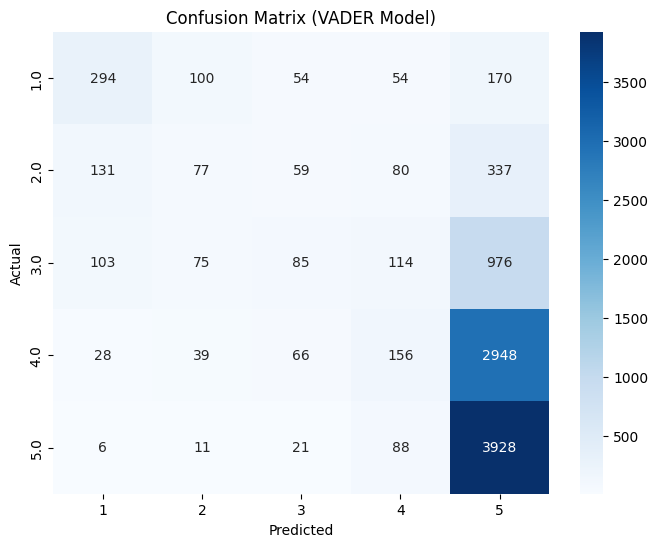

In [ ]:


    
dev_data['sentiment_outcome_vader'] = dev_data['clean_text'].apply(get_sentiment_score)


# Evaluate the VADER model
accuracy_vader = accuracy_score(dev_data['overall_rating'], dev_data['sentiment_outcome_vader'])
print(f"\n✅ VADER Model Accuracy: {accuracy_vader:.4f}")

# Classification Report
print("\n💡 **Classification Report (VADER Model):**")
print(classification_report(dev_data['overall_rating'], dev_data['sentiment_outcome_vader']))

# Confusion Matrix
conf_matrix = pd.crosstab(dev_data['overall_rating'], dev_data['sentiment_outcome_vader'], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (VADER Model)")
plt.show()




VADER’s performance in sentiment analysis is worse than the machine learning approach using Multinomial Naïve Bayes. This is likely because VADER is designed for quick, rule-based sentiment analysis, but it doesn’t learn from the data like a machine learning model does. In contrast, the TF-IDF model combined with Naïve Bayes can better capture complex sentiment patterns, leading to higher accuracy and more balanced predictions.

### 6. Combining VADER with the best classifier

In [ ]:

combination_data = dev_data[['clean_text','overall_rating']].copy()
process_combination_data = feature_extraction(combination_data, remove_stopwords=False, lemmatize=False)

process_combination_data['sentiment_score'] = process_combination_data['clean_text'].apply(get_sentiment_score)


print("vader, no stopwords, no lemmatization with ifidf")
evaluation(process_combination_data, vader=True)



vader, no stopwords, no lemmatization with ifidf
Vector Type: TfidfVector
Average Accuracy: 0.5744
Average F1 Score: 0.5781
Average F1 Score (Macro): 0.5111
Average F1 Score (Micro): 0.5744



 
1. Chaithra, V.D., 2019. Hybrid approach: naive bayes and sentiment VADER for analyzing sentiment of mobile unboxing video comments. International Journal of Electrical and Computer Engineering (IJECE), 9(5), pp.4452-4459.

In [ ]:
print(process_combination_data[['sentiment_score', 'overall_rating']].corr())

                 sentiment_score  overall_rating
sentiment_score         1.000000        0.568123
overall_rating          0.568123        1.000000


### 7. Trainig and testing the final method

In [ ]:
# train data 

training_data = train_data.copy()

training_data['overall_rating'] = training_data['ratings'].apply(lambda x: x["overall"])
# remove the row data if the overall_rating is 0
training_data = training_data[training_data['overall_rating'] != 0]

training_data = feature_extraction(training_data, remove_stopwords=False, lemmatize=False)
training_data['sentiment_score'] = training_data['clean_text'].apply(get_sentiment_score)



x_train = training_data[['clean_text', 'sentiment_score']]
x_train_vader = training_data['sentiment_score']
y_train = training_data['overall_rating']



tfidf_vectorizer = TfidfVectorizer()
X_train_vec = tfidf_vectorizer.fit_transform(x_train['clean_text'])

X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec, index=x_train.index, columns=tfidf_vectorizer.get_feature_names_out()).astype('float32')
X_train_vec = pd.concat([X_train_vec, x_train_vader], axis=1)

temp_sample = upsampling(pd.concat([X_train_vec, y_train], axis=1))

X_train_vec = temp_sample.drop('overall_rating', axis=1)
y_train = temp_sample['overall_rating']



mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

#==================================================================================================


# test data

testing_data = test_data.copy()

testing_data['overall_rating'] = testing_data['ratings'].apply(lambda x: x["overall"])
# remove the row data if the overall_rating is 0
testing_data = testing_data[testing_data['overall_rating'] != 0]
testing_data = feature_extraction(testing_data, remove_stopwords=False, lemmatize=False)
testing_data['sentiment_score'] = testing_data['clean_text'].apply(get_sentiment_score)



x_test = testing_data[['clean_text', 'sentiment_score']]
x_test_vader = testing_data['sentiment_score']
y_test = testing_data['overall_rating']







X_test_vec = tfidf_vectorizer.transform(x_test['clean_text'])
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec, index=x_test.index, columns=tfidf_vectorizer.get_feature_names_out()).astype('float32')

X_test_vec = pd.concat([X_test_vec, x_test_vader], axis=1)
y_pred = mnb.predict(X_test_vec)



# accuracy ,f1 score, classification report
print("test and train data with best combination")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')


print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))






test and train data with best combination
Accuracy: 0.5706
F1 Score: 0.5767
F1 Score (Macro): 0.5169
F1 Score (Micro): 0.5706

Classification Report:
              precision    recall  f1-score   support

         1.0       0.66      0.52      0.58       642
         2.0       0.34      0.37      0.35       683
         3.0       0.39      0.45      0.42      1350
         4.0       0.51      0.57      0.54      3221
         5.0       0.74      0.65      0.70      4103

    accuracy                           0.57      9999
   macro avg       0.53      0.51      0.52      9999
weighted avg       0.59      0.57      0.58      9999



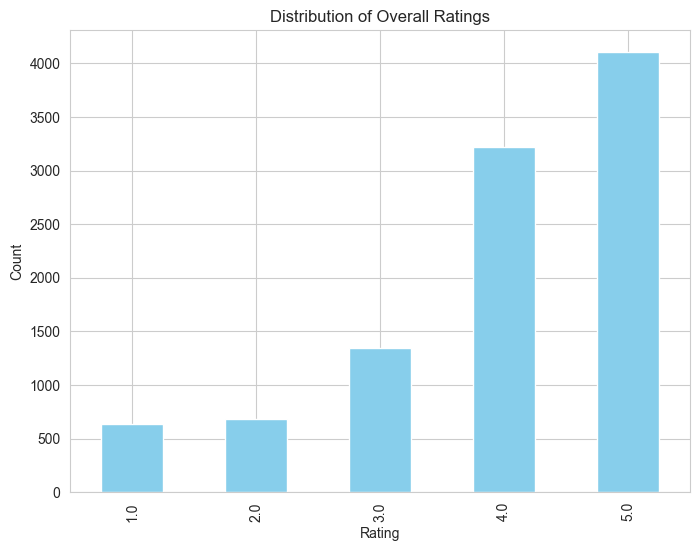

In [18]:
testing_data = test_data.copy()

# Extracting the "overall" rating from the 'ratings' column
testing_data['overall_rating'] = testing_data['ratings'].apply(lambda x: x["overall"])
testing_data = testing_data[testing_data['overall_rating'] != 0]



# Plot the distribution of overall ratings
plt.figure(figsize=(8, 6))
testing_data['overall_rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Distribution of Overall Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

The reason the results from the test data set are better than those from session 4 is because the test data set contains more data. When a model is trained on a larger dataset, it has more examples to learn from, which allows it to make better predictions on new, unseen data. This helps the model generalize well and reduces the risk of overfitting (memorizing specific data points). On the other hand, if there's not enough data, the model might not learn enough and could become too simple, leading to underfitting. In short, having more data helps the model find the right patterns, improving its performance by avoiding both overfitting and underfitting.

### 8. Reviews aspect prediction

1. Text Preprocessing:
I'll start by converting the title and text to lowercase, removing any non-alphanumeric characters, and splitting the text into individual words (tokenization). Then, I’ll get rid of common stopwords and use stemming or lemmatization to reduce words to their root forms. Finally, I’ll combine everything into a new column called clean_text.

2. Feature Extraction:
Next, I’ll use the clean_text as input for feature extraction, applying either TF-IDF or Word2Vec embeddings to turn the text into useful features. Since this is a multi-output classification task, I’ll also encode the ratings for each aspect using either Label Encoding or One-Hot Encoding.

3. Modeling:
For modeling, I’ll use a MultiOutputClassifier with Multinomial Naive Bayes (MultipleNB). This way, I'll train a separate model for each rating aspect (like service, cleanliness, etc.), so each one gets its own prediction based on the text data.

4. Evaluation:
To evaluate the model, I’ll focus on metrics like F1-score, Precision, and Recall, especially since some categories may be imbalanced. I’ll also run cross-validation to make sure the model performs well on unseen data and doesn’t just overfit to the training set.

### 9. References

1. Mikeusru, 2018. Use BeautifulSoup and WordCloud to visualize the most frequent words in Firefly. [online] Medium. Available at: <https://medium.com/@mikeusru/use-beautifulsoup-and-wordcloud-to-visualize-the-most-frequent-words-in-firefly-bc09e15bf2e7> [Accessed 02 February 2025].


2. GeeksforGeeks. (2024). Multiclass vs Multioutput Algorithms in Machine Learning. [online] Available at: <https://www.geeksforgeeks.org/multiclass-vs-multioutput-algorithms-in-machine-learning/> [Accessed 02 February 2025].


3. Chen, H., Hu, S., Hua, R. and Zhao, X. (2021). Improved naive Bayes classification algorithm for traffic risk management. EURASIP Journal on Advances in Signal Processing, 2021(1). doi:https://doi.org/10.1186/s13634-021-00742-6 [Accessed 02 February 2025].